In [1]:
from ismn.interface import ISMN_Interface
import numpy as np
import matplotlib.pyplot as plt  # matplotlib is not installed automatically

import ee

# Authenticate and initialize the Earth Engine session
ee.Authenticate()
ee.Initialize()

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [2]:
data_path = "./data/ismn_data/Data_separate_files_header_20210101_20211231_11662_WdqG_20241116"
ismn_data = ISMN_Interface(data_path, parallel=True)

Using the existing ismn metadata in data/ismn_data/Data_separate_files_header_20210101_20211231_11662_WdqG_20241116/python_metadata/Data_separate_files_header_20210101_20211231_11662_WdqG_20241116.csv to set up ISMN_Interface. 
If there are issues with the data reader, you can remove the metadata csv file to repeat metadata collection.


In [3]:
network_names = ['SNOTEL', 'USCRN', 'CW3E']
sensor_names = {'SNOTEL': 'Hydraprobe-Analog-(2.5-Volt)_soil_moisture_0.050800_0.050800', 
                'USCRN': 'Stevens-Hydraprobe-II-Sdi-12_soil_moisture_0.050000_0.050000', 
                'CW3E': 'CS616_soil_moisture_0.050000_0.050000'}

In [4]:
import pandas as pd

data_list = []
for network_name in network_names:
    for station in ismn_data[network_name].stations:
        if sensor_names[network_name] in ismn_data[network_name][station].sensors:
            d = ismn_data[network_name][station][sensor_names[network_name]].data
            timestamps = d.index#.to_list()
            soil_moisture = d['soil_moisture'].values.tolist()
            soil_moisture = np.array(soil_moisture)
            soil_moisture[soil_moisture == -9999] = np.nan
            soil_moisture = soil_moisture.tolist()
            longitude = ismn_data[network_name][station].metadata.to_dict()['longitude'][0][0]
            latitude = ismn_data[network_name][station].metadata.to_dict()['latitude'][0][0]
        else:
            print(f"Sensor {sensor_names[network_name]} not found for station {station} in network {network_name}")
            continue
        # Create rows for each timestamp and moisture value
        data_list.append({
            'network_name': network_name,
            'station': station,
            'sensor_name': sensor_names[network_name],
            'longitude': longitude,
            'latitude': latitude,
            'soil_moistures': soil_moisture,
            'timestamps': timestamps
        })

df = pd.DataFrame(data_list)

# Remove rows where max soil moisture > 10
df = df[df['soil_moistures'].apply(lambda x: np.nanmax(x) <= 10)]



Sensor Hydraprobe-Analog-(2.5-Volt)_soil_moisture_0.050800_0.050800 not found for station BERTHOUDSUMMIT in network SNOTEL
Sensor Hydraprobe-Analog-(2.5-Volt)_soil_moisture_0.050800_0.050800 not found for station CRATERMEADOWS in network SNOTEL
Sensor Hydraprobe-Analog-(2.5-Volt)_soil_moisture_0.050800_0.050800 not found for station DollarhideSummit in network SNOTEL
Sensor Hydraprobe-Analog-(2.5-Volt)_soil_moisture_0.050800_0.050800 not found for station FORTVALLEY in network SNOTEL
Sensor Hydraprobe-Analog-(2.5-Volt)_soil_moisture_0.050800_0.050800 not found for station GIVEOUT in network SNOTEL
Sensor Hydraprobe-Analog-(2.5-Volt)_soil_moisture_0.050800_0.050800 not found for station GROUSECAMP in network SNOTEL
Sensor Hydraprobe-Analog-(2.5-Volt)_soil_moisture_0.050800_0.050800 not found for station HYNDMAN in network SNOTEL
Sensor Hydraprobe-Analog-(2.5-Volt)_soil_moisture_0.050800_0.050800 not found for station LILYPOND in network SNOTEL
Sensor Hydraprobe-Analog-(2.5-Volt)_soil_mo

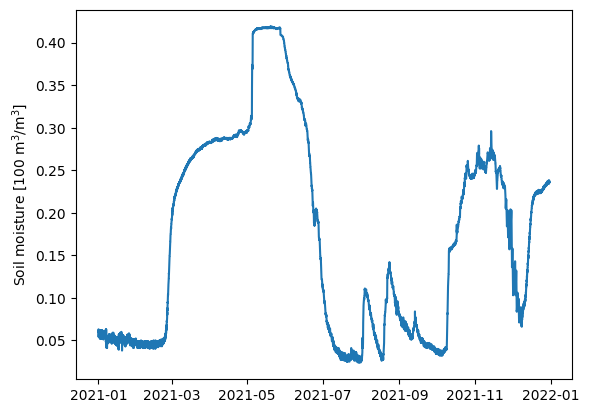

In [34]:
index = 230
plt.plot(df['timestamps'][index], df['soil_moistures'][index])
plt.ylabel('Soil moisture [100 m$^3$/m$^3$]')
plt.show()



In [147]:
df['timestamps'][300]

DatetimeIndex(['2021-01-01 02:00:00', '2021-01-01 03:00:00',
               '2021-01-01 04:00:00', '2021-01-01 05:00:00',
               '2021-01-01 06:00:00', '2021-01-01 07:00:00',
               '2021-01-01 08:00:00', '2021-01-01 09:00:00',
               '2021-01-01 10:00:00', '2021-01-01 11:00:00',
               ...
               '2021-12-30 11:00:00', '2021-12-30 12:00:00',
               '2021-12-30 13:00:00', '2021-12-30 14:00:00',
               '2021-12-30 15:00:00', '2021-12-30 16:00:00',
               '2021-12-30 17:00:00', '2021-12-30 18:00:00',
               '2021-12-30 19:00:00', '2021-12-30 20:00:00'],
              dtype='datetime64[ns]', name='date_time', length=8731, freq=None)

In [135]:
# Get coordinates from df





First few coordinates:
1. (37.52, -112.27)
2. (42.87, -122.17)
3. (40.35, -106.38)
4. (34.46, -111.38)
5. (33.98, -109.50)


In [166]:


def get_goes_data(coords, start_date, end_date):


    features = []
    for lat, lon in coords:
        point = ee.Geometry.Point(lon, lat)
        feature = ee.Feature(point, {'latitude': lat, 'longitude': lon})
        features.append(feature)
    points_fc = ee.FeatureCollection(features)

    # Define the time range for the time series data (hourly interval)


    bands_of_interest = ['CMI_C01', 'CMI_C02', 'CMI_C03', 'CMI_C04', 'CMI_C05', 'CMI_C06', 'CMI_C07', 'CMI_C08', 'CMI_C09', 'CMI_C10', 'CMI_C11', 'CMI_C12', 'CMI_C13', 'CMI_C14', 'CMI_C15', 'CMI_C16']

    # Select the ImageCollection you want to use and filter to hourly data
    collection = ee.ImageCollection("NOAA/GOES/16/MCMIPC") \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.calendarRange(40, 59, 'minute')) \
        .select(bands_of_interest)

    # Create a dictionary to store data for each point
    point_data = {}
    # Function to extract pixel values at the points for each image
    def extract_values(image):
        # This function needs to return a feature with the extracted values
        date = image.date().format('YYYY-MM-dd HH:mm:ss')  # Format to hour precision
        values = image.reduceRegions(
            collection=points_fc,
            reducer=ee.Reducer.first(),
            scale=10
        )
        
        # Add the date to each feature
        def add_date(feature):
            return feature.set('datetime', date)
        
        return values.map(add_date)

    # Process all images and get results
    results = collection.map(extract_values).flatten()
    results_list = results.getInfo()['features']

    # Initialize point_data dictionary
    point_data = {}

    # Process results
    for feature in results_list:
        coords = (feature['geometry']['coordinates'][1], feature['geometry']['coordinates'][0])
        if coords not in point_data:
            point_data[coords] = {
                'lat': coords[0],
                'long': coords[1],
                'datetime': [],
                'CMI_C01': [], 'CMI_C02': [], 'CMI_C03': [], 'CMI_C04': [],
                'CMI_C05': [], 'CMI_C06': [], 'CMI_C07': [], 'CMI_C08': [],
                'CMI_C09': [], 'CMI_C10': [], 'CMI_C11': [], 'CMI_C12': [],
                'CMI_C13': [], 'CMI_C14': [], 'CMI_C15': [], 'CMI_C16': []
            }
        
        point_data[coords]['datetime'].append(feature['properties']['datetime'])
        for band in bands_of_interest:
            if band in feature['properties']:
                point_data[coords][band].append(feature['properties'][band])

    # Convert to DataFrame
    df_goes = pd.DataFrame.from_dict(point_data, orient='index')
    df_goes = df_goes.reset_index(drop=True)
    return df_goes


In [191]:
coords = list(zip(df['latitude'], df['longitude']))
start_date = pd.Timestamp('2020-12-01T00:00:00')
end_date = pd.Timestamp('2020-12-31T23:59:00')

# Initialize empty DataFrame with the structure we need
df_goes = pd.DataFrame({
    'lat': [c[0] for c in coords],
    'long': [c[1] for c in coords],
    'datetime': [[] for _ in coords],
    'CMI_C01': [[] for _ in coords], 'CMI_C02': [[] for _ in coords],
    'CMI_C03': [[] for _ in coords], 'CMI_C04': [[] for _ in coords],
    'CMI_C05': [[] for _ in coords], 'CMI_C06': [[] for _ in coords],
    'CMI_C07': [[] for _ in coords], 'CMI_C08': [[] for _ in coords],
    'CMI_C09': [[] for _ in coords], 'CMI_C10': [[] for _ in coords],
    'CMI_C11': [[] for _ in coords], 'CMI_C12': [[] for _ in coords],
    'CMI_C13': [[] for _ in coords], 'CMI_C14': [[] for _ in coords],
    'CMI_C15': [[] for _ in coords], 'CMI_C16': [[] for _ in coords]
})

# Process in 2-hour chunks
while start_date < end_date:
    chunk_end = min(start_date + pd.Timedelta(hours=2), end_date)
    
    # Convert timestamps to strings in the required format
    start_str = start_date.strftime('%Y-%m-%dT%H:%M:%S')
    end_str = chunk_end.strftime('%Y-%m-%dT%H:%M:%S')
    
    # Get data for this chunk
    df_chunk = get_goes_data(coords, start_str, end_str)
    
    # Update arrays in df_goes with new values from df_chunk
    for idx in range(len(coords)):
        df_goes.at[idx, 'datetime'].extend(df_chunk.at[idx, 'datetime'])
        for band in [f'CMI_C{str(i).zfill(2)}' for i in range(1, 17)]:
            df_goes.at[idx, band].extend(df_chunk.at[idx, band])
    
    # Update start_date for next iteration
    start_date = chunk_end

KeyboardInterrupt: 

In [ ]:
coords = list(zip(df['latitude'], df['longitude']))

# Process data month by month for 2021
for month in range(1, 13):
    # Set start and end dates for the month
    if month == 12:
        start_date = pd.Timestamp(f'2021-{month:02d}-01T00:00:00')
        end_date = pd.Timestamp(f'2021-{month:02d}-31T23:59:00') 
    else:
        start_date = pd.Timestamp(f'2021-{month:02d}-01T00:00:00')
        end_date = pd.Timestamp(f'2021-{month+1:02d}-01T00:00:00')

    # Initialize empty DataFrame for this month
    df_goes = pd.DataFrame({
        'lat': [c[0] for c in coords],
        'long': [c[1] for c in coords],
        'datetime': [[] for _ in coords],
        'CMI_C01': [[] for _ in coords], 'CMI_C02': [[] for _ in coords],
        'CMI_C03': [[] for _ in coords], 'CMI_C04': [[] for _ in coords],
        'CMI_C05': [[] for _ in coords], 'CMI_C06': [[] for _ in coords],
        'CMI_C07': [[] for _ in coords], 'CMI_C08': [[] for _ in coords],
        'CMI_C09': [[] for _ in coords], 'CMI_C10': [[] for _ in coords],
        'CMI_C11': [[] for _ in coords], 'CMI_C12': [[] for _ in coords],
        'CMI_C13': [[] for _ in coords], 'CMI_C14': [[] for _ in coords],
        'CMI_C15': [[] for _ in coords], 'CMI_C16': [[] for _ in coords]
    })

    # Process in 2-hour chunks
    current_date = start_date
    while current_date < end_date:
        chunk_end = min(current_date + pd.Timedelta(hours=2), end_date)
        
        # Convert timestamps to strings in the required format
        start_str = current_date.strftime('%Y-%m-%dT%H:%M:%S')
        end_str = chunk_end.strftime('%Y-%m-%dT%H:%M:%S')
        
        # Get data for this chunk
        df_chunk = get_goes_data(coords, start_str, end_str)
        
        # Update arrays in df_goes with new values from df_chunk
        for idx in range(len(coords)):
            df_goes.at[idx, 'datetime'].extend(df_chunk.at[idx, 'datetime'])
            for band in [f'CMI_C{str(i).zfill(2)}' for i in range(1, 17)]:
                df_goes.at[idx, band].extend(df_chunk.at[idx, band])
        
        # Update current_date for next iteration
        current_date = chunk_end

    # Save the month's data to CSV
    output_filename = f'goes_data_2021_{month:02d}.csv'
    df_goes.to_csv(output_filename, index=False)
    print(f"Saved data for month {month} to {output_filename}")

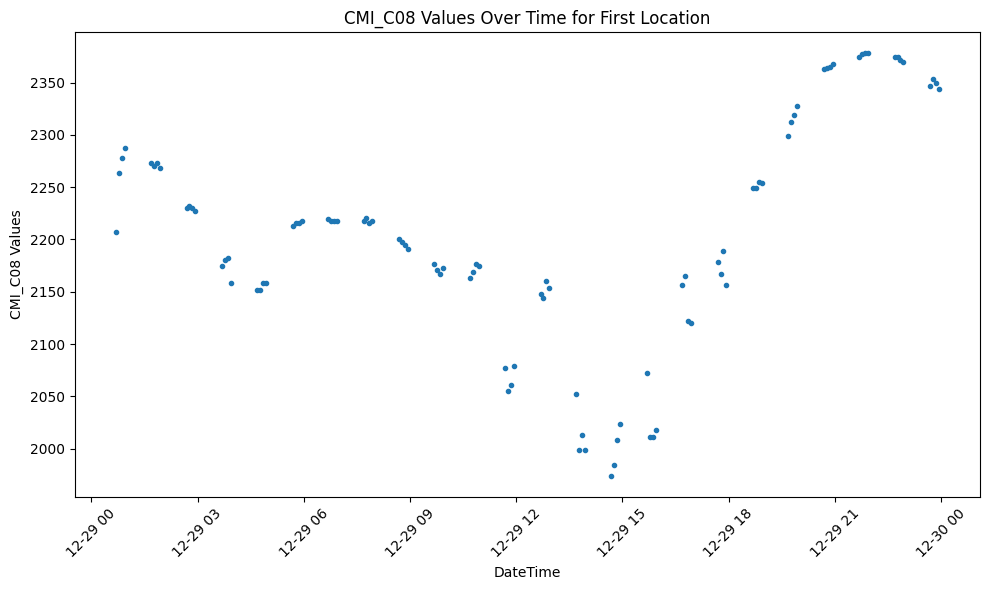

In [185]:
import matplotlib.pyplot as plt
import pandas as pd

# Get first row data
dates = pd.to_datetime(df_goes.iloc[0]['datetime'])
values = df_goes.iloc[0]['CMI_C08']

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(dates, values, '.')
plt.xlabel('DateTime') 
plt.ylabel('CMI_C08 Values')
plt.title('CMI_C08 Values Over Time for First Location')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [187]:
df_goes

,lat,long,datetime,CMI_C01,CMI_C02,CMI_C03,CMI_C04,CMI_C05,CMI_C06,CMI_C07,CMI_C08,CMI_C09,CMI_C10,CMI_C11,CMI_C12,CMI_C13,CMI_C14,CMI_C15,CMI_C16
0,37.52000,-112.27000,"[2020-12-29 00:41:18, 2020-12-29 00:46:18, 202...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, ...","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4423, 4950, 5076, 5021, 5063, 5035, 5049, 502...","[2207, 2264, 2278, 2288, 2273, 2270, 2273, 226...","[2336, 2439, 2466, 2470, 2461, 2463, 2466, 246...","[2283, 2410, 2439, 2433, 2444, 2447, 2448, 244...","[2353, 2546, 2593, 2577, 2587, 2588, 2588, 258...","[2378, 2470, 2490, 2483, 2490, 2492, 2492, 249...","[2633, 2796, 2836, 2826, 2837, 2836, 2836, 283...","[2571, 2759, 2801, 2789, 2803, 2801, 2801, 280...","[2560, 2737, 2784, 2770, 2788, 2787, 2787, 278...","[2706, 2861, 2903, 2893, 2906, 2903, 2906, 290..."
1,42.87000,-122.17000,"[2020-12-29 00:41:18, 2020-12-29 00:46:18, 202...","[34, 20, 12, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[19, 12, 6, 3, 1, 0, 0, 1, 0, 0, 1, 0, 1, 2, 1...","[28, 21, 18, 12, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...","[4, 4, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, ...","[5, 3, 4, 3, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5230, 5218, 5230, 5193, 5142, 5155, 5142, 512...","[2150, 2156, 2154, 2156, 2160, 2158, 2156, 216...","[2413, 2418, 2418, 2420, 2420, 2420, 2425, 242...","[2453, 2456, 2458, 2457, 2452, 2453, 2454, 245...","[2630, 2630, 2625, 2624, 2612, 2609, 2608, 260...","[2447, 2445, 2445, 2445, 2444, 2442, 2442, 244...","[2882, 2878, 2878, 2876, 2863, 2861, 2860, 285...","[2849, 2847, 2845, 2843, 2832, 2830, 2828, 282...","[2837, 2834, 2833, 2832, 2818, 2817, 2817, 281...","[2903, 2903, 2900, 2900, 2893, 2893, 2893, 289..."
2,40.35000,-106.38000,"[2020-12-29 00:41:18, 2020-12-29 00:46:18, 202...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1920, 2042, 1920, 2042, 2042, 1920, 1920, 192...","[1956, 1945, 1937, 1937, 1937, 1932, 1945, 193...","[1991, 1975, 1971, 1962, 1966, 1954, 1979, 195...","[1913, 1897, 1887, 1887, 1887, 1878, 1901, 187...","[1831, 1808, 1804, 1802, 1806, 1791, 1816, 179...","[2149, 2139, 2137, 2134, 2137, 2134, 2142, 213...","[2183, 2165, 2163, 2159, 2157, 2150, 2169, 214...","[2125, 2108, 2105, 2100, 2099, 2089, 2107, 208...","[2108, 2092, 2087, 2082, 2081, 2070, 2092, 207...","[2338, 2331, 2323, 2327, 2323, 2312, 2327, 231..."
3,34.46000,-111.38000,"[2020-12-29 00:41:18, 2020-12-29 00:46:18, 202...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3177, 3177, 3079, 2917, 2664, 2858, 2973, 279...","[2064, 2074, 2068, 2066, 2041, 2050, 2059, 205...","[2134, 2148, 2141, 2134, 2104, 2121, 2134, 213...","[2054, 2072, 2065, 2052, 2012, 2035, 2050, 204...","[2019, 2044, 2021, 2005, 1947, 1990, 1999, 199...","[2276, 2287, 2278, 2267, 2242, 2258, 2269, 226...","[2349, 2368, 2354, 2341, 2302, 2327, 2345, 233...","[2270, 2288, 2277, 2267, 2237, 2258, 2272, 226...","[2244, 2264, 2254, 2243, 2216, 2238, 2247, 224...","[2470, 2487, 2474, 2467, 2443, 2460, 2467, 246..."
4,33.98000,-109.50000,"[2020-12-29 00:41:18, 2020-12-29 00:46:18, 202...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."